In [10]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import shutil as sh
import math
import time
from mpl_toolkits.mplot3d import Axes3D

In [11]:
class vdw_phi():
    
    #ヘリンボーンパラメータとYorZ入れる。glide=a→Z, glide=b→Y
    def __init__(self,R1,R2,heri,glide):
        self.R1=R1;self.R2=R2;self.heri=heri;self.glide=glide
        self.path='C:\\Users\\youmo\\OSC\\interaction\\mono-C9-BTBT\\vdw\\'
        self.interval_phi1=1#deg
        self.interval_phi2=1#deg
        self.phi1_list=np.linspace(-180.0,180.0,360.0/self.interval_phi1+1)#回転角
        self.phi2_list=[0]#np.linspace(-3.0,5.0,8.0/self.interval_phi2+1)#結合角まだ試作段階#################
        
        A_rad=np.radians(heri/2)
        self.a_=2*(R1*np.cos(A_rad)-R2*np.sin(A_rad))
        self.b_=2*(R2*np.cos(A_rad)+R1*np.sin(A_rad))
        
        #侵入の閾値
        self.inv=1.0

    #theta_in 
    def Rod(self,n,theta_in):
        nx,ny,nz=n
        theta_t=np.radians(theta_in)
        Rod=np.array([[np.cos(theta_t)+(nx**2)*(1-np.cos(theta_t)),nx*ny*(1-np.cos(theta_t))-nz*np.sin(theta_t),nx*nz*(1-np.cos(theta_t))+ny*np.sin(theta_t)],
                    [nx*ny*(1-np.cos(theta_t))+nz*np.sin(theta_t),np.cos(theta_t)+(ny**2)*(1-np.cos(theta_t)),ny*nz*(1-np.cos(theta_t))-nx*np.sin(theta_t)],
                    [nx*nz*(1-np.cos(theta_t))-ny*np.sin(theta_t),ny*nz*(1-np.cos(theta_t))+nx*np.sin(theta_t),np.cos(theta_t)+(nz**2)*(1-np.cos(theta_t))]])
        return Rod


    #分子1分子2を作成(回転させただけ・平行移動なし)
    def convertor(self,atom_list,A,phi1,phi2):#A=heri/2
        atom_list_1=[];atom_list_pa=[];atom_list_pb=[];atom_list_t1=[];atom_list_t3=[]
        
        #alkylの基準
        C0=np.array([atom_list[16][0],atom_list[16][1],atom_list[16][2]])
        C1=np.array([atom_list[23][0],atom_list[23][1],atom_list[23][2]])
        C2=np.array([atom_list[26][0],atom_list[26][1],atom_list[26][2]])
        
        #phi1に関するalkylの軸
        n1=C1-C0
        n1/=np.linalg.norm(n1)
        
        n2=np.cross(C0-C1,C2-C1)
        n2/=np.linalg.norm(n2)
                    
        #alkyl回転・分子1作成
        for ind,(x,y,z,R) in enumerate(atom_list):
            if ind>=23:#alkyl?
                x,y,z=np.matmul(self.Rod(n2,phi2),(np.array([x,y,z])-C1).T)
                x,y,z=C1+np.array([x,y,z])
                x,y,z=np.matmul(self.Rod(n1,phi1),(np.array([x,y,z])-C0).T)
                x,y,z=C0+np.array([x,y,z])
            x1,y1,z1=np.matmul(self.Rod(np.array([0,0,1]),A),np.array([x,y,z]).T)
            atom_list_1.append([x1,y1,z1,R])
        
        #並進・映進操作でp,t作成
        for x,y,z,R in atom_list_1:
            atom_list_pb.append([x,self.b_+y,z,R])
            atom_list_pa.append([self.a_+x,y,z,R])
            
            if self.glide=='a':
                atom_list_t1.append([self.a_/2+x,self.b_/2-y,z,R])
                atom_list_t3.append([-self.a_/2+x,-self.b_/2-y,z,R])

            elif self.glide=='b':
                atom_list_t1.append([self.a_/2-x,self.b_/2+y,z,R])
                atom_list_t3.append([-self.a_/2-x,-self.b_/2+y,z,R])

        atom_list_others=[atom_list_pa,atom_list_pb,atom_list_t1,atom_list_t3]
        return atom_list_1,atom_list_others

    #phiの範囲を出力
    def calc_phi(self):
        df=pd.DataFrame(columns=['R1','R2','heri','phi1','phi2'])
        df_mono=pd.read_csv(self.path+'monomer_cifopt.csv') ###x,y,z,rad##################test中
        monomer=df_mono[['X','Y','Z','R']].values

        for phi1 in self.phi1_list:
            for phi2 in self.phi2_list:
                BTBT_1,BTBT_others=self.convertor(monomer,self.heri/2,phi1,phi2)

                #衝突回数
                clps=0

                #アルキルの各原子同士が衝突したらbreak
                for ind1,(x1,y1,z1,R1) in enumerate(BTBT_1[23:]):
                    if clps>0:
                        break
                    for ind2,BTBT_2 in enumerate(BTBT_others):
                        if clps>0:
                            break
                        for ind3,(x2,y2,z2,R2) in enumerate(BTBT_2[23:]):
                            if (R1+R2)-np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2) > self.inv:
                                clps+=1
                                break
                if clps==0:
                    data=pd.Series([self.R1,self.R2,self.heri,phi1,phi2],index=['R1','R2','heri','phi1','phi2'])
                    df=df.append(data,ignore_index=True)
        df.to_csv(self.path+'vdw_phi_cifopt.csv',index=False)

    def pieplot(self):
        df_vdw_phi=pd.read_csv(self.path+'vdw_phi_cifopt.csv')
        phi_list=df_vdw_phi['phi1'].values#接触が少なかったphiのリスト
        
        pie=1;pie_list=[]#円グラフにおけるpieの大きさとそのリスト
        
        inc_bool_old=(180.0 in phi_list) #一周してつながるようにする
        
        for phi in self.phi1_list[1:]:#180deg=-180degでした
            inc_bool_new=(phi in phi_list)#含まれてるかどうかのbool値
            if inc_bool_old == inc_bool_new:#続くならpie増加
                pie+=1
            else:#途切れたら色スイッチ
                pie_list.append(pie)
                pie=1
            inc_bool_old=inc_bool_new
        pie_list.append(pie-1)
        color_list=['skyblue' if i%2==1 else 'white' for i in range(len(pie_list))] #0or1の振動で表現
        print(pie_list)
        plt.pie(pie_list,colors=color_list,counterclock=False,startangle=self.heri/2+90-180)#90が12時のところ。phi1の最初が-180degなので180引いた

In [7]:
vdw=vdw_phi(R1=5.0,R2=0.8,heri=58.0,glide='b')

In [8]:
vdw.calc_phi()

[37, 10, 48, 3, 75, 72, 115]


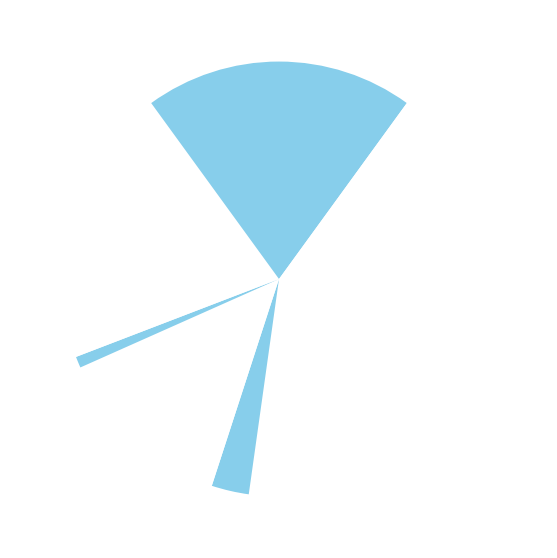

In [9]:
plt.rcParams['figure.figsize']=10,10
vdw.pieplot()

In [104]:
df=pd.read_csv(vdw.path+'vdw_phi.csv')
df_mono=pd.read_csv(vdw.path+'monomer.csv')###x,y,z,rad
monomer=df_mono[['X','Y','Z','R']].values

atom_list_1,atom_list_others=vdw.convertor(monomer,vdw.heri/2,-135.0,0.0)
df_test=pd.DataFrame(np.array(atom_list_1+atom_list_others[2]+atom_list_others[3]),columns=['X','Y','Z','R'])
df_test.to_csv(vdw.path+'test.csv',index=False)